#### *CARREGAMENTO DE ARQUIVO*

In [2]:
# Passo 1: Carregar os microdados do ENEM 2023
caminho_arquivo = r"C:/Users/Usuario/Desktop/Fea.Dev/Análise-Novembro/DADOS/MICRODADOS_ENEM_2023.csv" #Trocar para o o seu caminho do arquivo, deixei o meu 
enem_data = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1')


In [6]:
# Recarregar os dados do shapefile e do ENEM
shapefile_path = 'br.shp'
mapa_brasil = gpd.read_file(shapefile_path)

#### *Código para o mapa com as médias por estado*

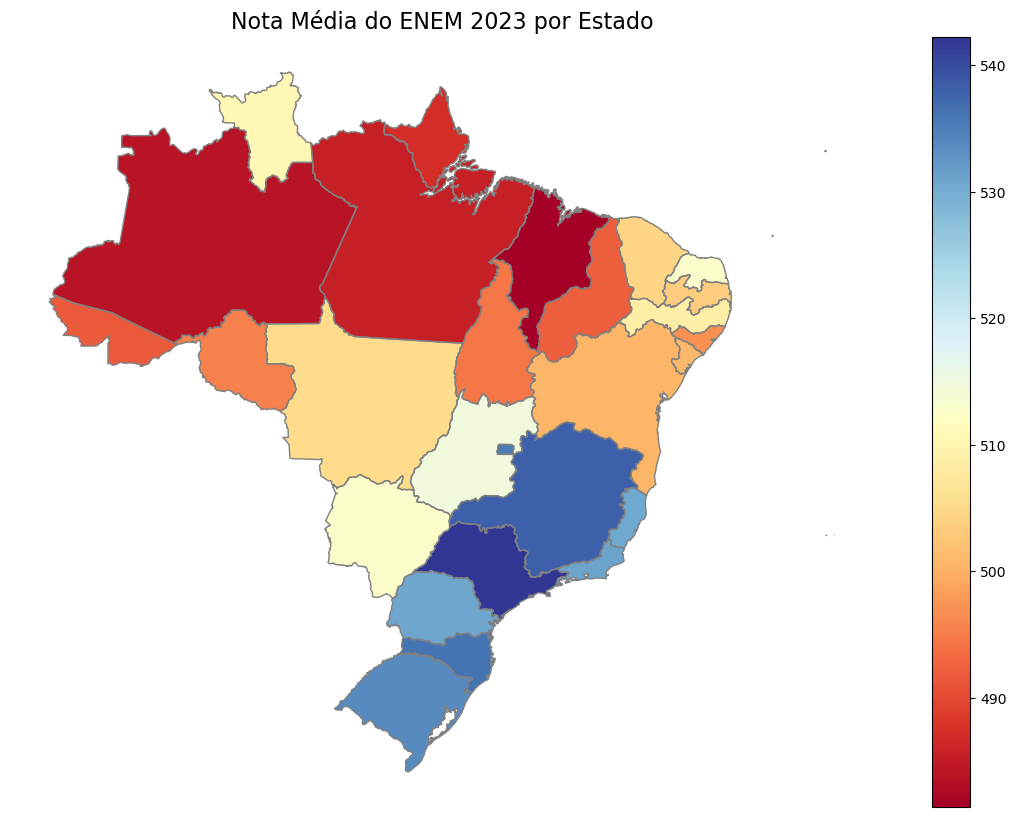

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import unicodedata

# Função para normalizar nomes
def normalizar_nome(nome):
    if pd.isna(nome):
        return nome
    return ''.join(c for c in unicodedata.normalize('NFD', nome) if unicodedata.category(c) != 'Mn')

# Normalizar os nomes no shapefile
mapa_brasil['name'] = mapa_brasil['name'].apply(normalizar_nome)

# mapeamento de nomes para siglas
mapeamento_manual = {
    "Acre": "AC", "Alagoas": "AL", "Amazonas": "AM", "AmapA¡": "AP", "Bahia": "BA",
    "CearA¡": "CE", "Distrito Federal": "DF", "EspA­rito Santo": "ES", "GoiA¡s": "GO",
    "MaranhA£o": "MA", "Minas Gerais": "MG", "Mato Grosso do Sul": "MS", "Mato Grosso": "MT",
    "ParA¡": "PA", "ParaA­ba": "PB", "Pernambuco": "PE", "PiauA­": "PI", "ParanA¡": "PR",
    "Rio de Janeiro": "RJ", "Rio Grande do Norte": "RN", "RondA´nia": "RO", "Roraima": "RR",
    "Rio Grande do Sul": "RS", "Santa Catarina": "SC", "Sergipe": "SE", "SA£o Paulo": "SP",
    "Tocantins": "TO"
}

# Mapear os estados no shapefile para as siglas do ENEM
mapa_brasil['SG_UF_PROVA'] = mapa_brasil['name'].map(mapeamento_manual)


# Selecionar as colunas relevantes e calcular a média
colunas_interesse = ['SG_UF_PROVA', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
enem_data = enem_data[colunas_interesse]
enem_data['NOTA_MEDIA'] = enem_data[['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']].mean(axis=1)
media_por_estado = enem_data.groupby('SG_UF_PROVA')['NOTA_MEDIA'].mean().reset_index()

# Mesclar os dados do ENEM com o shapefile
mapa_brasil = mapa_brasil.merge(media_por_estado, on='SG_UF_PROVA', how='left')

# Ajustar escala com base nas notas mínima e máxima
nota_min = mapa_brasil['NOTA_MEDIA'].min()
nota_max = mapa_brasil['NOTA_MEDIA'].max()

# Plotar o mapa com gradiente de cores
plt.figure(figsize=(15, 10))
mapa_brasil.boundary.plot(ax=plt.gca(), linewidth=1, color='gray')
mapa_brasil.plot(
    column='NOTA_MEDIA', 
    ax=plt.gca(), 
    cmap='RdYlBu',  # Gradiente vermelho para azul
    legend=True, 
    vmin=nota_min,
    vmax=nota_max
)

# Títulos e configurações finais
plt.title('Nota Média do ENEM 2023 por Estado', fontsize=16)
plt.axis('off')
plt.show()


#### *Mapa Virtual*
Mais bonito e completo, entretanto não consegui baixar.

In [5]:
import folium
from folium import Choropleth
# Criar o mapa base centralizado no Brasil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB positron')

# Adicionar o choropleth ao mapa
Choropleth(
    geo_data=mapa_brasil,  # Dados geográficos
    data=mapa_brasil,      # Dados com valores a serem plotados
    columns=['SG_UF_PROVA', 'NOTA_MEDIA'],  # Colunas: identificação e valor
    key_on='feature.properties.SG_UF_PROVA',  # Chave para unir os dados
    fill_color='YlGnBu',  # Paleta de cores
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Nota Média do ENEM 2023'
).add_to(m)

# Exibir o mapa
m.save("mapa_interativo.html")